In [1]:
import os
import torch
import nibabel as nib
import numpy as np
import random
from scipy.ndimage import rotate

In [2]:
def load_brats_folder(root_dir, max_samples=50):
    folder_list = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
    folder_list = folder_list[:max_samples]  # Lấy 50 mẫu đầu tiên
    data_tensors = []
    for folder in folder_list:
        folder_path = os.path.join(root_dir, folder)
        sample_id = folder
        flair_path = os.path.join(folder_path, f'{sample_id}_flair.nii.gz')
        t1_path = os.path.join(folder_path, f'{sample_id}_t1.nii.gz')
        t1ce_path = os.path.join(folder_path, f'{sample_id}_t1ce.nii.gz')
        t2_path = os.path.join(folder_path, f'{sample_id}_t2.nii.gz')
        seg_path = os.path.join(folder_path, f'{sample_id}_seg.nii.gz')
        
        if not all(os.path.exists(p) for p in [flair_path, t1_path, t1ce_path, t2_path, seg_path]):
            print(f"Warning: Missing files in folder {folder}. Skipping...")
            continue
        
        # Đọc dữ liệu
        flair = nib.load(flair_path).get_fdata()
        t1 = nib.load(t1_path).get_fdata()
        t1ce = nib.load(t1ce_path).get_fdata()
        t2 = nib.load(t2_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()
        
        # Kiểm tra shape
        shapes = [flair.shape, t1.shape, t1ce.shape, t2.shape, seg.shape]
        if not all(s == shapes[0] for s in shapes):
            print(f"Warning: Shape mismatch in {sample_id}. Skipping...")
            continue
        
        # Chuyển thành tensor
        flair_tensor = torch.from_numpy(flair).float().unsqueeze(0)
        t1_tensor = torch.from_numpy(t1).float().unsqueeze(0)
        t1ce_tensor = torch.from_numpy(t1ce).float().unsqueeze(0)
        t2_tensor = torch.from_numpy(t2).float().unsqueeze(0)
        seg_tensor = torch.from_numpy(seg).long()  # Không thêm chiều kênh ở đây
        
        vol_tensor = torch.cat([flair_tensor, t1_tensor, t1ce_tensor, t2_tensor], dim=0)
        sample = {'id': sample_id, 'vol': vol_tensor, 'seg': seg_tensor}
        data_tensors.append(sample)
        print(f"Loaded {sample_id} - vol shape: {vol_tensor.shape}, seg shape: {seg_tensor.shape}")
    return data_tensors

In [3]:
# Đường dẫn tới thư mục dữ liệu
root_dir = r'C:\Users\Heathcliff\Desktop\mmFormer_GA_Joint\dschettler8845\brats-2021-task1\versions\1\training'

# Gọi hàm để đọc dữ liệu
data_tensors = load_brats_folder(root_dir)

# Ví dụ truy cập dữ liệu
for sample in data_tensors[:5]:  # In thông tin 5 mẫu đầu tiên
    print(f"Sample {sample['id']}: vol shape = {sample['vol'].shape}, seg shape = {sample['seg'].shape}")

Loaded BraTS2021_00000 - vol shape: torch.Size([4, 240, 240, 155]), seg shape: torch.Size([240, 240, 155])
Loaded BraTS2021_00002 - vol shape: torch.Size([4, 240, 240, 155]), seg shape: torch.Size([240, 240, 155])
Loaded BraTS2021_00003 - vol shape: torch.Size([4, 240, 240, 155]), seg shape: torch.Size([240, 240, 155])
Loaded BraTS2021_00005 - vol shape: torch.Size([4, 240, 240, 155]), seg shape: torch.Size([240, 240, 155])
Loaded BraTS2021_00006 - vol shape: torch.Size([4, 240, 240, 155]), seg shape: torch.Size([240, 240, 155])
Loaded BraTS2021_00008 - vol shape: torch.Size([4, 240, 240, 155]), seg shape: torch.Size([240, 240, 155])
Loaded BraTS2021_00009 - vol shape: torch.Size([4, 240, 240, 155]), seg shape: torch.Size([240, 240, 155])
Loaded BraTS2021_00011 - vol shape: torch.Size([4, 240, 240, 155]), seg shape: torch.Size([240, 240, 155])
Loaded BraTS2021_00012 - vol shape: torch.Size([4, 240, 240, 155]), seg shape: torch.Size([240, 240, 155])
Loaded BraTS2021_00014 - vol shape: t

In [4]:
# Ví dụ truy cập dữ liệu
for sample in data_tensors[:5]:  # In thông tin 5 mẫu đầu tiên
    print(f"Sample {sample['id']}: vol shape = {sample['vol'].shape}, seg shape = {sample['seg'].shape}")

Sample BraTS2021_00000: vol shape = torch.Size([4, 240, 240, 155]), seg shape = torch.Size([240, 240, 155])
Sample BraTS2021_00002: vol shape = torch.Size([4, 240, 240, 155]), seg shape = torch.Size([240, 240, 155])
Sample BraTS2021_00003: vol shape = torch.Size([4, 240, 240, 155]), seg shape = torch.Size([240, 240, 155])
Sample BraTS2021_00005: vol shape = torch.Size([4, 240, 240, 155]), seg shape = torch.Size([240, 240, 155])
Sample BraTS2021_00006: vol shape = torch.Size([4, 240, 240, 155]), seg shape = torch.Size([240, 240, 155])


In [ ]:
# Các lớp biến đổi (tạm thời không dùng trong inference sliding window)
class CenterCrop:
    def __init__(self, size):
        self.size = size
        self.buffer = None

    def sample(self, *shape):
        size = self.size
        start = [(s - size) // 2 for s in shape]
        self.buffer = [slice(None)] + [slice(s, s + size) for s in start]
        return [size] * len(shape)

    def tf(self, img, k=0):
        return img[tuple(self.buffer)]

class RandomRotion:
    def __init__(self, angle_spectrum=10):
        self.angle_spectrum = angle_spectrum
        self.axes = [(1, 0), (2, 1), (2, 0)]
        self.axes_buffer = None
        self.angle_buffer = None

    def sample(self, *shape):
        self.axes_buffer = self.axes[np.random.choice(len(self.axes))]
        self.angle_buffer = np.random.randint(-self.angle_spectrum, self.angle_spectrum)
        return list(shape)

    def tf(self, img, k=0):
        bsize = img.shape[0]
        for bs in range(bsize):
            if k == 0:
                channels = [rotate(img[bs, :, :, :, c], self.angle_buffer, axes=self.axes_buffer, 
                                   reshape=False, order=0, mode='constant', cval=-1) 
                            for c in range(img.shape[4])]
                img[bs, ...] = np.stack(channels, axis=-1)
            elif k == 1:
                img[bs, ...] = rotate(img[bs, ...], self.angle_buffer, axes=self.axes_buffer, 
                                      reshape=False, order=0, mode='constant', cval=-1)
        return img

class RandomFlip:
    def __init__(self):
        self.axis = (1, 2, 3)
        self.x_buffer = None
        self.y_buffer = None
        self.z_buffer = None

    def sample(self, *shape):
        self.x_buffer = np.random.choice([True, False])
        self.y_buffer = np.random.choice([True, False])
        self.z_buffer = np.random.choice([True, False])
        return list(shape)

    def tf(self, img, k=0):
        if self.x_buffer:
            img = np.flip(img, axis=self.axis[0])
        if self.y_buffer:
            img = np.flip(img, axis=self.axis[1])
        if self.z_buffer:
            img = np.flip(img, axis=self.axis[2])
        return img

class Compose:
    def __init__(self, ops):
        self.ops = ops

    def sample(self, *shape):
        for op in self.ops:
            shape = op.sample(*shape)

    def tf(self, img, k=0):
        for op in self.ops:
            img = op.tf(img, k)
        return img

# Hàm áp dụng biến đổi (giữ nguyên để tạo transformed_data)
def apply_transform(sample):
    vol = sample['vol'].numpy()  # Shape: (4, H, W, D)
    seg = sample['seg'].numpy()  # Shape: (H, W, D)
    
    vol = vol[np.newaxis, ...]  # Shape: (1, 4, H, W, D)
    seg = seg[np.newaxis, ...]  # Shape: (1, H, W, D)
    
    vol = np.transpose(vol, (0, 2, 3, 4, 1))  # Shape: (1, H, W, D, 4)
    
    crop = CenterCrop(size=128)
    rotation = RandomRotion(angle_spectrum=10)
    flip = RandomFlip()
    
    transform = Compose([crop, rotation, flip])
    transform.sample(240, 240, 155)
    
    vol_transformed = transform.tf(vol, k=0)
    seg_transformed = transform.tf(seg, k=1)
    
    vol_transformed = np.ascontiguousarray(vol_transformed[0].transpose(3, 0, 1, 2))
    seg_transformed = np.ascontiguousarray(seg_transformed[0])
    
    vol_transformed = torch.from_numpy(vol_transformed).float()  # Shape: (4, 128, 128, 128)
    seg_transformed = torch.from_numpy(seg_transformed).long()  # Shape: (128, 128, 128)
    
    return {'id': sample['id'], 'vol': vol_transformed, 'seg': seg_transformed}

In [6]:
# Áp dụng biến đổi và visualize (giả sử data_tensors đã được tải)
transformed_data = [apply_transform(sample) for sample in data_tensors]

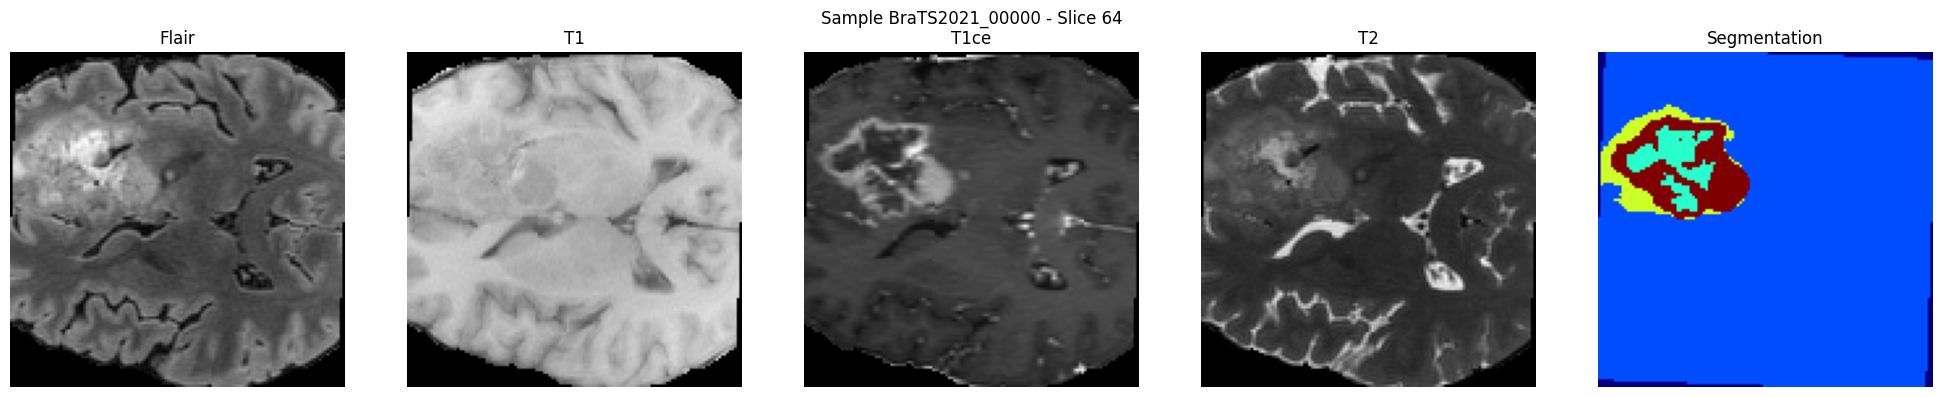

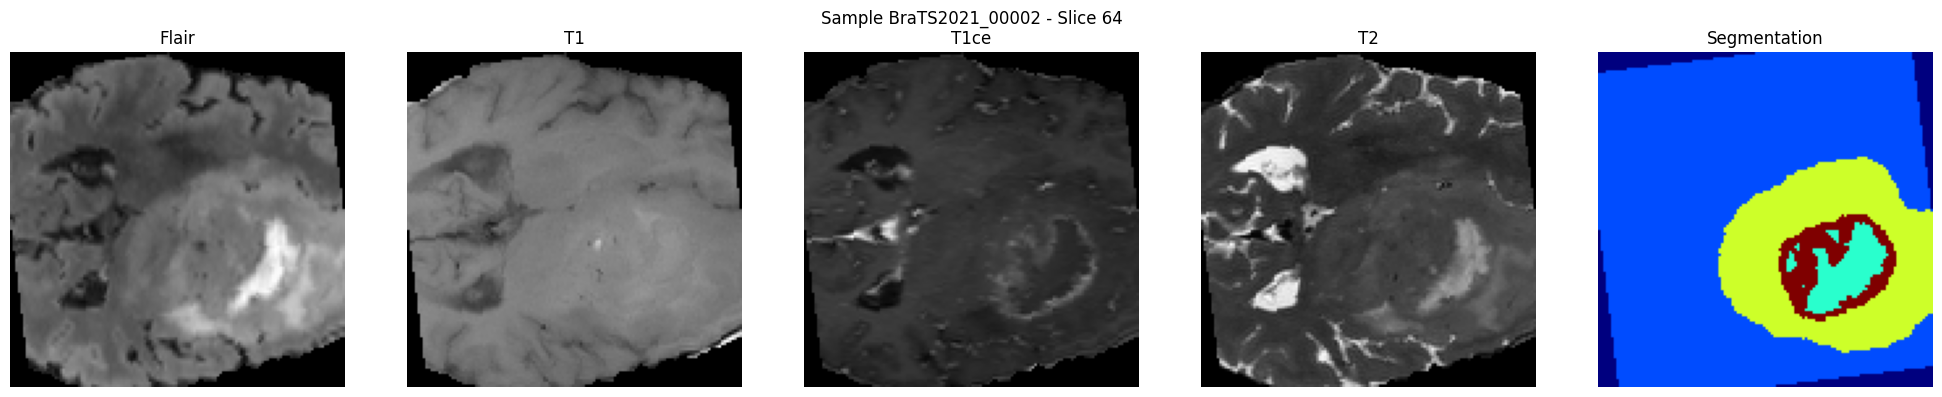

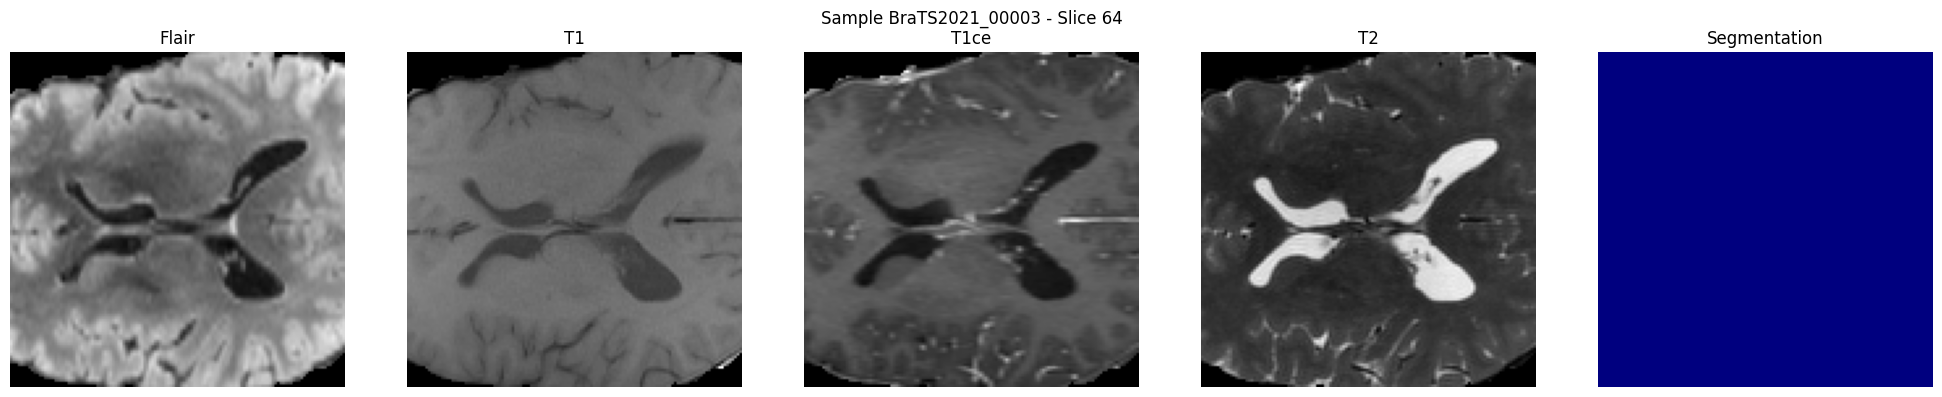

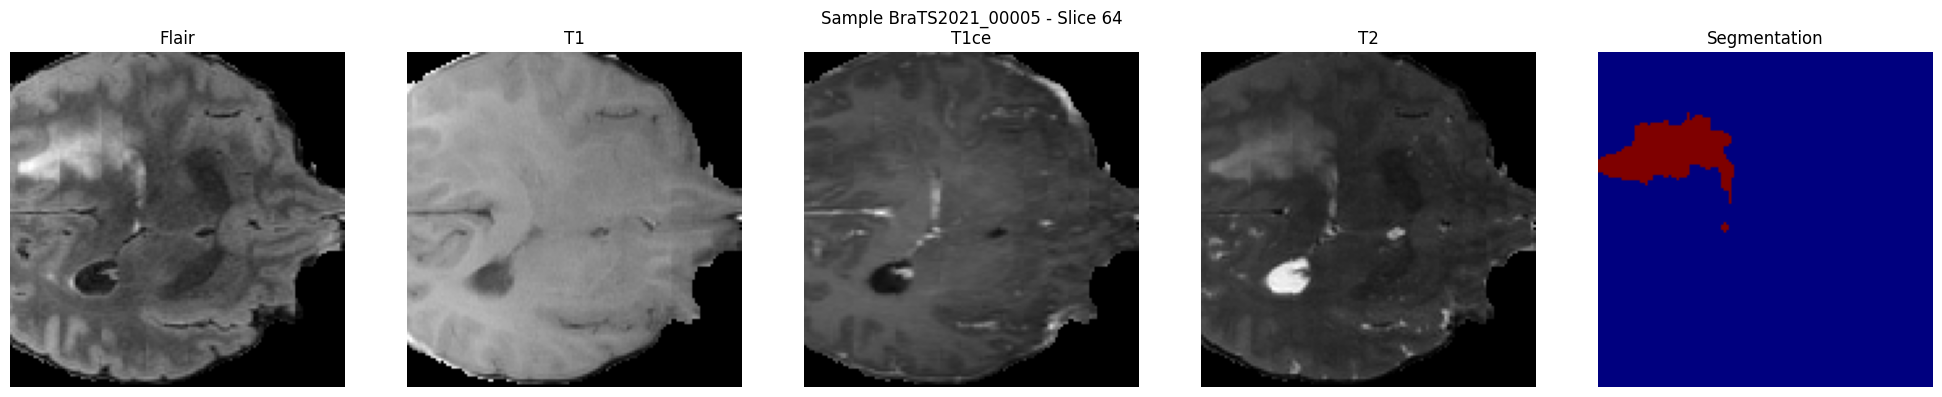

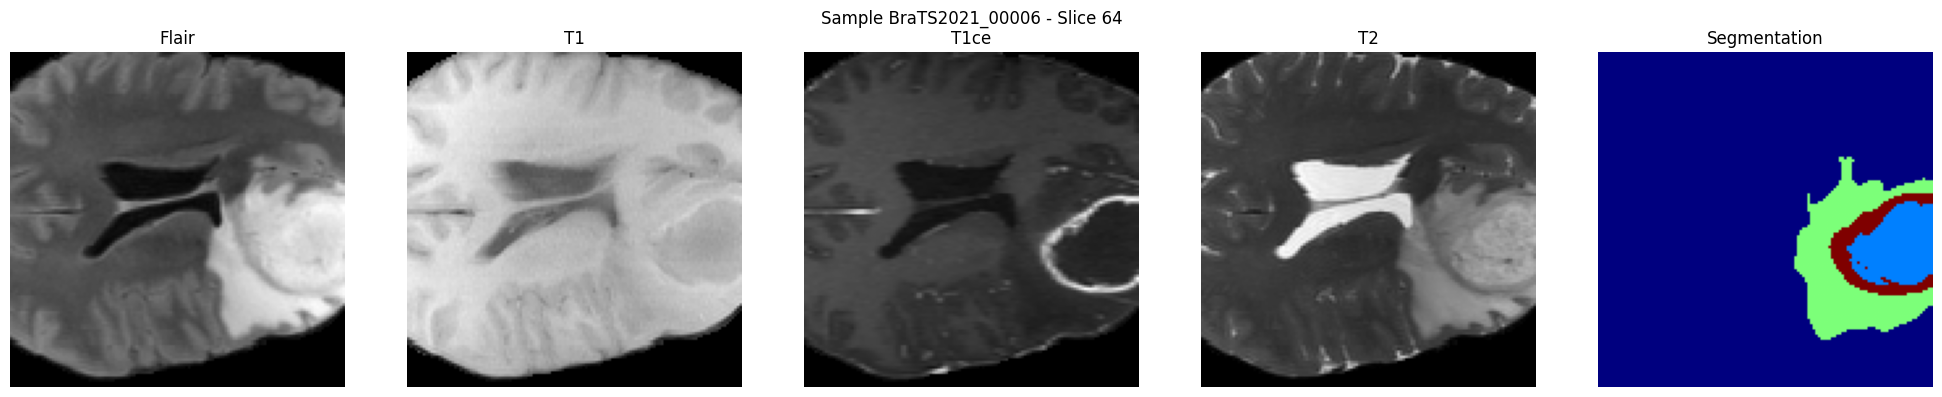

In [ ]:
import matplotlib.pyplot as plt

# Hàm visualize dữ liệu
def visualize_sample(sample, slice_idx=None, sample_id="Unknown"):
    vol = sample['vol']  # Shape: (4, H, W, D)
    seg = sample['seg']  # Shape: (H, W, D)
    
    # Lấy lát cắt giữa nếu không chỉ định slice_idx
    if slice_idx is None:
        slice_idx = vol.shape[3] // 2  # Giữa chiều D
    
    # Tạo figure với 5 subplots (4 kênh MRI + 1 segmentation)
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # Các tên kênh MRI
    modalities = ['Flair', 'T1', 'T1ce', 'T2']
    
    # Visualize từng kênh của vol
    for i, ax in enumerate(axes[:4]):
        ax.imshow(vol[i, :, :, slice_idx], cmap='gray')
        ax.set_title(modalities[i])
        ax.axis('off')
    
    # Visualize segmentation
    axes[4].imshow(seg[:, :, slice_idx], cmap='jet')
    axes[4].set_title('Segmentation')
    axes[4].axis('off')
    
    plt.suptitle(f"Sample {sample_id} - Slice {slice_idx}")
    plt.tight_layout()
    plt.show()

# Visualize 5 mẫu đầu tiên, truyền thêm id từ data_tensors
for i, sample in enumerate(transformed_data[:5]):
    sample_id = data_tensors[i]['id']  # Lấy id từ data_tensors
    visualize_sample(sample, sample_id=sample_id)

In [ ]:
import mmformer

def load_mmformer(checkpoint_path=None):
    model = mmformer.Model(num_cls=4)  # num_cls=4 vì BRATS có 4 lớp (background, NCR/NET, ED, ET)
    model.is_training = False  # Chạy ở chế độ inference
    
    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint)
        print(f"Loaded checkpoint from {checkpoint_path}")
    
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    return model

# Hàm inference với sliding window tối ưu bộ nhớ
def predict_sliding_window(model, vol, device='cuda', patch_size=128, overlap=0.5):
    model = model.to(device)
    vol = vol.to(device)  # Shape: (4, 240, 240, 155)
    B, C, H, W, D = vol.shape[0], vol.shape[1], 240, 240, 155
    
    if vol.dim() == 4:
        vol = vol.unsqueeze(0)  # Shape: (1, 4, 240, 240, 155)
    
    # Tính toán các chỉ số sliding window
    stride = int(patch_size * (1 - overlap))  # 64 nếu overlap=0.5
    h_idx_list = list(range(0, H - patch_size + 1, stride)) + [H - patch_size]
    w_idx_list = list(range(0, W - patch_size + 1, stride)) + [W - patch_size]
    d_idx_list = list(range(0, D - patch_size + 1, stride)) + [D - patch_size]
    
    # Khởi tạo pred và weight trên CPU để tiết kiệm GPU memory
    pred = torch.zeros(B, 4, H, W, D, dtype=torch.float32, device='cpu')
    weight = torch.zeros(B, 4, H, W, D, dtype=torch.float32, device='cpu')
    one_patch = torch.ones(1, patch_size, patch_size, patch_size, dtype=torch.float32, device=device)
    
    # Inference từng patch
    with torch.no_grad():
        for h in h_idx_list:
            for w in w_idx_list:
                for d in d_idx_list:
                    # Lấy patch từ vol
                    patch = vol[:, :, h:h+patch_size, w:w+patch_size, d:d+patch_size]  # Shape: (1, 4, 128, 128, 128)
                    
                    # Tạo mask và GAMask cho patch hiện tại
                    mask = torch.ones(1, C, patch_size, patch_size, patch_size, dtype=torch.float32, device=device)
                    GAMask = torch.ones(1, C, patch_size, patch_size, patch_size, dtype=torch.float32, device=device)
                    
                    # Dự đoán patch
                    pred_patch = model(patch, mask, GAMask)  # Shape: (1, 4, 128, 128, 128)
                    
                    # Chuyển pred_patch về CPU và tích lũy
                    pred[:, :, h:h+patch_size, w:w+patch_size, d:d+patch_size] += pred_patch.cpu()
                    weight[:, :, h:h+patch_size, w:w+patch_size, d:d+patch_size] += one_patch.expand(1, 4, -1, -1, -1).cpu()
                    
                    # Giải phóng bộ nhớ GPU
                    del patch, mask, GAMask, pred_patch
                    torch.cuda.empty_cache()
    
    # Chuẩn hóa và lấy argmax trên CPU
    pred = pred / weight  # Shape: (1, 4, 240, 240, 155)
    pred = torch.argmax(pred, dim=1)  # Shape: (1, 240, 240, 155)
    
    return pred.squeeze(0)  # Shape: (240, 240, 155)

In [17]:
# Hàm visualize với sliding window
def visualize_sample_with_prediction(sample, pred, slice_idx=None):
    vol = sample['vol']  # Shape: (4, 240, 240, 155) - cần dữ liệu gốc
    seg = sample['seg']  # Shape: (240, 240, 155) - cần dữ liệu gốc
    pred = pred  # Shape: (240, 240, 155)
    
    if slice_idx is None:
        slice_idx = vol.shape[3] // 2  # Giữa chiều D
    
    fig, axes = plt.subplots(1, 6, figsize=(24, 4))
    modalities = ['Flair', 'T1', 'T1ce', 'T2']
    
    for i, ax in enumerate(axes[:4]):
        ax.imshow(vol[i, :, :, slice_idx], cmap='gray')
        ax.set_title(modalities[i])
        ax.axis('off')
    
    axes[4].imshow(seg[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    axes[4].set_title('Ground Truth')
    axes[4].axis('off')
    
    axes[5].imshow(pred[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
    axes[5].set_title('Prediction')
    axes[5].axis('off')
    
    plt.suptitle(f"Sample {sample['id']} - Slice {slice_idx}")
    plt.tight_layout()
    plt.show()

In [14]:
model = load_mmformer()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
original_data = []
for sample in data_tensors[:5]:  # Chỉ lấy 5 mẫu đầu tiên
        vol = sample['vol']  # Shape: (4, 240, 240, 155)
        seg = sample['seg']  # Shape: (240, 240, 155)
        original_data.append({'id': sample['id'], 'vol': vol, 'seg': seg})

In [19]:
# Dự đoán và visualize
for sample in original_data:
    pred = predict_sliding_window(model, sample['vol'], device, patch_size=128, overlap=0.5)
    visualize_sample_with_prediction(sample, pred)

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.50 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 10.56 GiB is allocated by PyTorch, and 116.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)